# Strategy Analysis with **Pandas TA** and AI/ML
* This is a **Work in Progress** and subject to change!
* Contributions are welcome and accepted!
* Examples below are for **educational purposes only**.
* **NOTE:** The **watchlist** module is independent of Pandas TA. To easily use it, copy it from your local pandas_ta installation directory into your project directory.

### Required Packages
##### Uncomment the packages you need to install or are missing

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install mplfinance
#!pip install pandas-datareader
#!pip install requests_cache
#!pip install tqdm
#!pip install alphaVantage-api # Required for Watchlist

In [2]:
%pylab inline
import datetime as dt
import random as rnd
from sys import float_info as sflt

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option("max_rows", 100)
pd.set_option("max_columns", 20)

import mplfinance as mpf
import pandas_ta as ta

from tqdm.notebook import trange, tqdm

from watchlist import colors, Watchlist # Is this failing? If so, copy it locally. See above.

print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"mplfinance v{mpf.__version__}")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib
Numpy v1.20.3
Pandas v1.3.0
mplfinance v0.12.7a17

Pandas TA v0.3.32b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



### MISC Function(s)

In [3]:
def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

## Data Collection

In [4]:
tf = "D"
tickers = ["SPY", "QQQ", "AAPL", "TSLA", "BTC-USD"]
watch = Watchlist(tickers, tf=tf, ds_name="yahoo", timed=True)
# watch.strategy = ta.CommonStrategy # If you have a Custom Strategy, you can use it here.
watch.load(tickers, analyze=True, verbose=False)

[!] Loading All: SPY, QQQ, AAPL, TSLA, BTC-USD
[i] Loaded SPY[D]: SPY_D.csv
[i] Runtime: 736.1327 ms (0.7361 s)
[+] Downloading[yahoo]: QQQ[D]
[+] Saving: /Users/kj/av_data/QQQ_D.csv
[i] Runtime: 697.6427 ms (0.6976 s)
[+] Downloading[yahoo]: AAPL[D]
[+] Saving: /Users/kj/av_data/AAPL_D.csv
[i] Runtime: 679.9694 ms (0.6800 s)
[+] Downloading[yahoo]: TSLA[D]
[+] Saving: /Users/kj/av_data/TSLA_D.csv
[i] Runtime: 738.0908 ms (0.7381 s)
[+] Downloading[yahoo]: BTC-USD[D]
[+] Saving: /Users/kj/av_data/BTC-USD_D.csv
[i] Runtime: 755.3894 ms (0.7554 s)


# Asset Selection

In [16]:
ticker = tickers[2] # change tickers by changing the index
print(f"{ticker} {watch.data[ticker].shape}\nColumns: {', '.join(list(watch.data[ticker].columns))}")

AAPL (10361, 12)
Columns: Open, High, Low, Close, Volume, Dividends, Stock Splits, SMA_10, SMA_20, SMA_50, SMA_200, VOL_SMA_20


### Trim it

In [17]:
duration = "1y"
asset = watch.data[ticker]
recent = recent_bars(asset, duration)
asset.columns = asset.columns.str.lower()
asset.drop(columns=["dividends", "split"], errors="ignore", inplace=True)
asset = asset.copy().tail(recent)
asset

,open,high,low,close,volume,stock splits,sma_10,sma_20,sma_50,sma_200,vol_sma_20
Date,,,,,,,,,,,
2021-01-15,127.990959,129.422138,126.221866,126.361008,111598500,0.0,128.677734,129.754095,123.478919,103.135757,1.127449e+08
2021-01-19,126.997087,127.921397,126.162237,127.046783,90757300,0.0,128.520701,129.710862,123.738876,103.468593,1.125648e+08
2021-01-20,127.871707,131.678242,127.762380,131.221054,104319500,0.0,128.622076,129.977717,124.001358,103.826647,1.081537e+08
2021-01-21,132.980205,138.814235,132.771485,136.031387,120150900,0.0,129.642783,130.407070,124.362730,104.182751,1.080986e+08
2021-01-22,135.445012,138.993146,134.192737,138.217926,114459400,0.0,130.452789,130.764368,124.814942,104.553542,1.053764e+08
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-07,172.889999,174.139999,171.029999,172.169998,86580100,0.0,177.556999,176.122500,164.787658,145.042709,1.032868e+08
2022-01-10,169.080002,172.500000,168.169998,172.190002,106765600,0.0,176.742999,175.759500,165.184505,145.300422,1.028636e+08
2022-01-11,172.320007,175.179993,170.820007,175.080002,76138300,0.0,176.322000,175.726500,165.694471,145.571689,9.900872e+07


# Trend Creation
A **Trend** is the result of some calculation or condition of one or more indicators. For simplicity, a _Trend_ is either ```True``` or ```1``` and _No Trend_ is ```False``` or ```0```. Using the **Hello World** of Trends, the **Golden/Death Cross**, it's Trend is _Long_ when ```long = ma(close, 50) > ma(close, 200) ``` and _Short_ when ```short = ma(close, 50) < ma(close, 200) ```. 

In [18]:
# Example Long Trends
# long = ta.sma(asset.close, 50) > ta.sma(asset.close, 200) # SMA(50) > SMA(200) "Golden/Death Cross"
# long = ta.sma(asset.close, 10) > ta.sma(asset.close, 20) # SMA(10) > SMA(20)
long = ta.ema(asset.close, 8) > ta.ema(asset.close, 21) # EMA(8) > EMA(21)
# long = ta.increasing(ta.ema(asset.close, 50))
# long = ta.macd(asset.close).iloc[:,1] > 0 # MACD Histogram is positive
# long = ta.amat(asset.close, 50, 200).AMATe_LR_2  # Long Run of AMAT(50, 200) with lookback of 2 bars

# long &= ta.increasing(ta.ema(asset.close, 50), 2) # Uncomment for further long restrictions, in this case when EMA(50) is increasing/sloping upwards
# long = 1 - long # uncomment to create a short signal of the trend

asset.ta.ema(length=8, sma=False, append=True)
asset.ta.ema(length=21, sma=False, append=True)
asset.ta.ema(length=50, sma=False, append=True)
asset.ta.percent_return(append=True)
print("TA Columns Added:")
asset[asset.columns[5:]].tail()

TA Columns Added:


,stock splits,sma_10,sma_20,sma_50,sma_200,vol_sma_20,EMA_8,EMA_21,EMA_50,PCTRET_1
Date,,,,,,,,,,
2022-01-07,0.0,177.556999,176.122500,164.787658,145.042709,1.032868e+08,175.550651,174.090649,166.893160,0.000988
2022-01-10,0.0,176.742999,175.759500,165.184505,145.300422,1.028636e+08,174.803840,173.917863,167.100879,0.000116
2022-01-11,0.0,176.322000,175.726500,165.694471,145.571689,9.900872e+07,174.865210,174.023512,167.413786,0.016784
2022-01-12,0.0,175.937000,175.786500,166.230213,145.852622,9.577525e+07,175.012941,174.160465,167.732069,0.002570
2022-01-13,0.0,175.637000,175.581499,166.738185,146.120707,9.070764e+07,175.054509,174.254968,168.024929,-0.001880


### **Trend Signals** 
Given a _Trend_, **Trend Signals** returns the _Trend_, _Trades_, _Entries_ and _Exits_ as boolean integers. When ```asbool=True```, it returns _Trends_, _Entries_ and _Exits_ as boolean values which is helpful when combined with the [**vectorbt**](https://github.com/polakowo/vectorbt) backtesting package.

In [19]:
trendy = asset.ta.tsignals(long, asbool=False, append=True)
trendy.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
Date,,,,
2022-01-07,1,0,0,0
2022-01-10,1,0,0,0
2022-01-11,1,0,0,0
2022-01-12,1,0,0,0
2022-01-13,1,0,0,0


### Trend Entries & Exits & Trade Table
This is a simple way to reduce the Asset DataFrame to a Trade Table with Dates, Signals, and Entries and Exits. Gives you an idea what to expect before running through a backtester such as [**vectorbt**](https://github.com/polakowo/vectorbt).

In [20]:
entries = trendy.TS_Entries * asset.close
entries = entries[~np.isclose(entries, 0)]
entries.dropna(inplace=True)
entries.name = "Entry"

exits = trendy.TS_Exits * asset.close
exits = exits[~np.isclose(exits, 0)]
exits.dropna(inplace=True)
exits.name = "Exit"

total_trades = trendy.TS_Trades.abs().sum()
rt_trades = int(trendy.TS_Trades.abs().sum() // 2)

all_trades = trendy.TS_Trades.copy().fillna(0)
all_trades = all_trades[all_trades != 0]

trades = pd.DataFrame({
    "Signal": all_trades,
    entries.name: entries,
    exits.name: exits
})

# Show some stats if there is an active trade (when there is an odd number of round trip trades)
if total_trades % 2 != 0:
    unrealized_pnl = asset.close.iloc[-1] - entries.iloc[-1]
    unrealized_pnl_pct_change = 100 * ((asset.close.iloc[-1] / entries.iloc[-1]) - 1)
    print("Current Trade:")
    print(f"Price Entry | Last:\t{entries.iloc[-1]:.4f} | {asset.close.iloc[-1]:.4f}")
    print(f"Unrealized PnL | %:\t{unrealized_pnl:.4f} | {unrealized_pnl_pct_change:.4f}%")
print(f"\nTrades Total | Round Trip:\t{total_trades} | {rt_trades}")
print(f"Trade Coverage: {100 * asset.TS_Trends.sum() / asset.shape[0]:.2f}%")

trades

Current Trade:
Price Entry | Last:	148.5432 | 175.2000
Unrealized PnL | %:	26.6568 | 17.9455%

Trades Total | Round Trip:	5 | 2
Trade Coverage: 59.13%


,Signal,Entry,Exit
Date,,,
2021-04-06,1,125.624153,NaN
2021-05-06,-1,NaN,129.137772
2021-06-14,1,130.094925,NaN
2021-09-16,-1,NaN,148.573151
2021-10-19,1,148.543198,NaN


# Visualization

### Chart Display Strings

In [21]:
extime = ta.get_time(to_string=True)
first_date, last_date = asset.index[0], asset.index[-1]
f_date = f"{first_date.day_name()} {first_date.month}-{first_date.day}-{first_date.year}"
l_date = f"{last_date.day_name()} {last_date.month}-{last_date.day}-{last_date.year}"
last_ohlcv = f"Last OHLCV: ({asset.iloc[-1].open:.4f}, {asset.iloc[-1].high:.4f}, {asset.iloc[-1].low:.4f}, {asset.iloc[-1].close:.4f}, {int(asset.iloc[-1].volume)})"
ptitle = f"\n{ticker} [{tf} for {duration}({recent} bars)] from {f_date} to {l_date}\n{last_ohlcv}\n{extime}"

### Trade Chart

<AxesSubplot:title={'center':'\nAAPL [D for 1y(252 bars)] from Friday 1-15-2021 to Thursday 1-13-2022\nLast OHLCV: (175.7800, 176.6200, 174.5300, 175.2000, 29711051)\nThursday January 13, 2022, NYSE: 4:44:17, Local: 8:44:17 PST, Day 13/365 (4.00%)'}, xlabel='Date'>

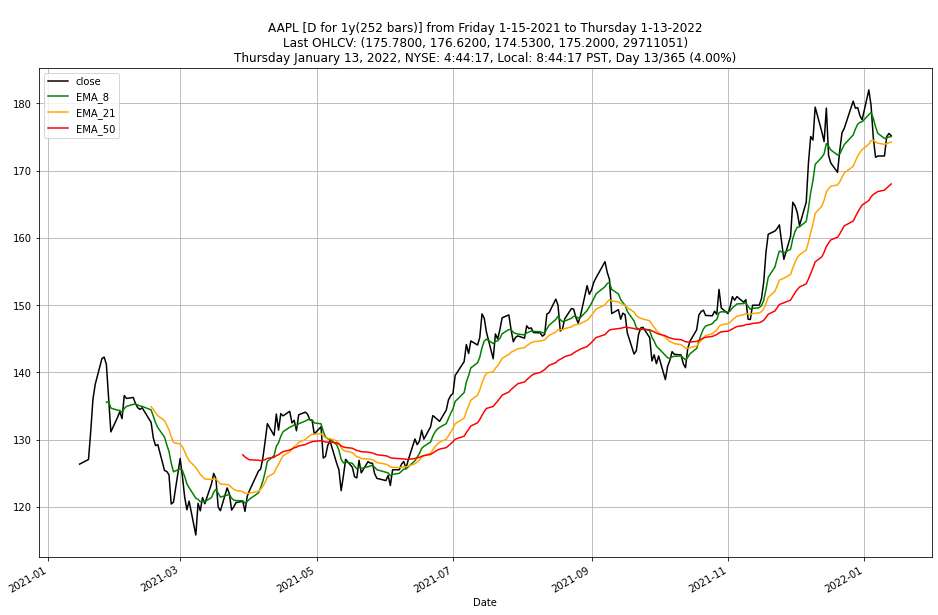

In [22]:
# chart = asset["close"] #asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]]
# chart = asset[["close", "SMA_10", "SMA_20"]]
chart = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=ptitle, grid=True)

### Long and Short Trends
**Trends** are either a _Trend_ (```1```) or _No Trend_ (```0```) depending on the **Trend** passed into ***Trend Signals**

<AxesSubplot:xlabel='Date'>

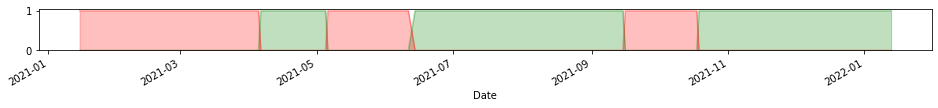

In [23]:
long_trend = trendy.TS_Trends
short_trend = 1 - long_trend

long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[0], alpha=0.25) # Green Area
short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[1], alpha=0.25) # Red Area

### Trades or Trade Signals
The **Trades** are either _Enter_ (```1```) or _Exit_ (```-1```) or _No Position/Action_ (```0```). These are based on the **Trend** passed into **Trend Signals** whether they are _Long_ or _Short_ Trends.

<AxesSubplot:xlabel='Date'>

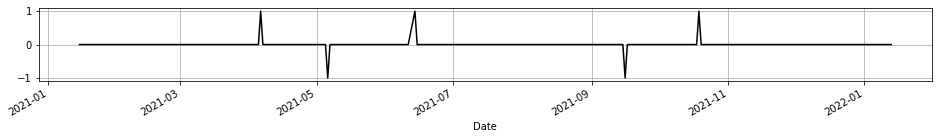

In [24]:
trendy.TS_Trades.plot(figsize=(16, 1.5), color=colors("BkBl")[0], grid=True)

### Active Returns
**Active Returns** are returns made during the course of the _Trend_. They are simply the product of the returns and the _Trend_

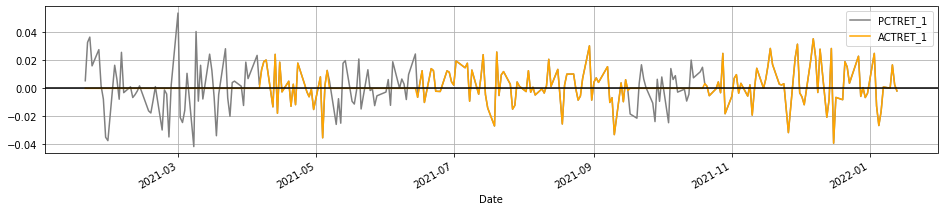

In [25]:
asset["ACTRET_1"] = trendy.TS_Trends.shift(1) * asset.PCTRET_1
asset[["PCTRET_1", "ACTRET_1"]].plot(figsize=(16, 3), color=colors("GyOr"), alpha=1, grid=True).axhline(0, color="black")

### Buy and Hold Returns (*PCTRET_1*) vs. Cum. Active Returns (*ACTRET_1*)

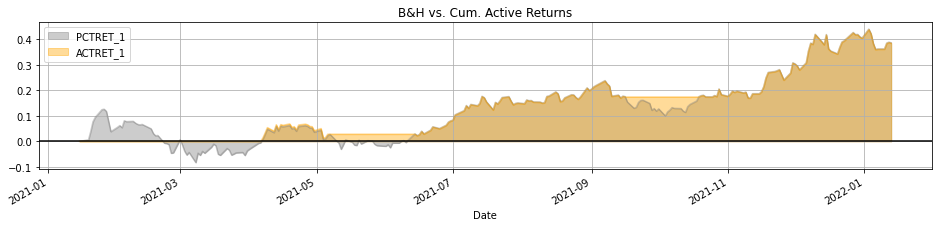

In [26]:
((asset[["PCTRET_1", "ACTRET_1"]] + 1).cumprod() - 1).plot(figsize=(16, 3), kind="area", stacked=False, color=colors("GyOr"), title="B&H vs. Cum. Active Returns", alpha=.4, grid=True).axhline(0, color="black")

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.